In [15]:
import numpy as np #numpy for math operation
import os
from utils import concatenate_scan_set, makeSparseDataFromRasterRepeat, computeVLIV, vlivCPUFitExp, load_nested_data_pickle, LIV_fun
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
# from time import time
from tqdm import tqdm
import cv2
from natsort import natsorted
from pydicom import dcmread
import pickle
import matplotlib.gridspec as gridspec
data_path = "D:/globus slate shared data Tankam Lab/without_H2O2_registered_intervolume/registered_cropped_top/"
average_LivCurve = True
fitting_method = "CPU"
frameSeparationTime = 0.001 #1ms frame to frame time interval
alivInitial  = 1 #initla guess for aliv parameter curve fitting
swiftInitial = 1 # initial guess for swiftness parameter curve fitting
bounds = (0, np.inf)
# save_dcm_pickle(data_path)

put everything in a scan in a pickle file 

In [2]:
scan_name = natsorted(os.listdir(data_path))[10]
dcm_name = natsorted(os.listdir(os.path.join(data_path, scan_name)))[0]

# ds = dcmread(os.path.join(data_path, scan_name, dcm_name))
# arr = ds.pixel_array
# plt.imshow(arr, cmap="gray")

C:\Users\liu473\AppData\Local\Temp\6\ipykernel_33312\1509972911.py:2: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  volume = pickle.load(handle)


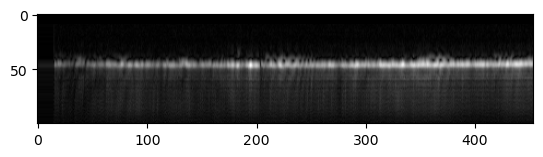

In [3]:
with open(os.path.join(data_path, scan_name, f'{scan_name}.pickle'), 'rb') as handle:
    volume = pickle.load(handle)

plt.imshow(volume[1, :, :], cmap="gray")

In [4]:
image_list = os.listdir(data_path)#list all images address in data_path
fourD_image_volume_complete = load_nested_data_pickle(data_path, len(image_list))#load all image volume and combine them in one 4D np array
fourD_image = fourD_image_volume_complete[:, 40:50, :, 100:300]

In [5]:
concatenate_set = concatenate_scan_set(fourD_image)

In [6]:
blockRepeat = fourD_image.shape[0]
blockPerVolume = 1 #only 1 block is used in our protocal
bscanLocationPerBlock = fourD_image.shape[1] #the number of B-scan in one 3D volume

In [7]:
numLocation = bscanLocationPerBlock * blockPerVolume # Number of total B-scan

print('Processing: ' + data_path)

## OCT intensity
height = concatenate_set.shape[1]
width = concatenate_set.shape[2]

aliv = np.zeros((numLocation, height, width))
swift = np.zeros((numLocation, height, width))

Processing: D:/globus slate shared data Tankam Lab/without_H2O2_registered_intervolume/registered_cropped_top/


In [ ]:
# floc = 4
# sparseSequence, timePoints, frameindex = makeSparseDataFromRasterRepeat(concatenate_set, bscanLocationPerBlock, blockRepeat, floc)

In [ ]:
# print(frameindex)

range(4, 200, 10)


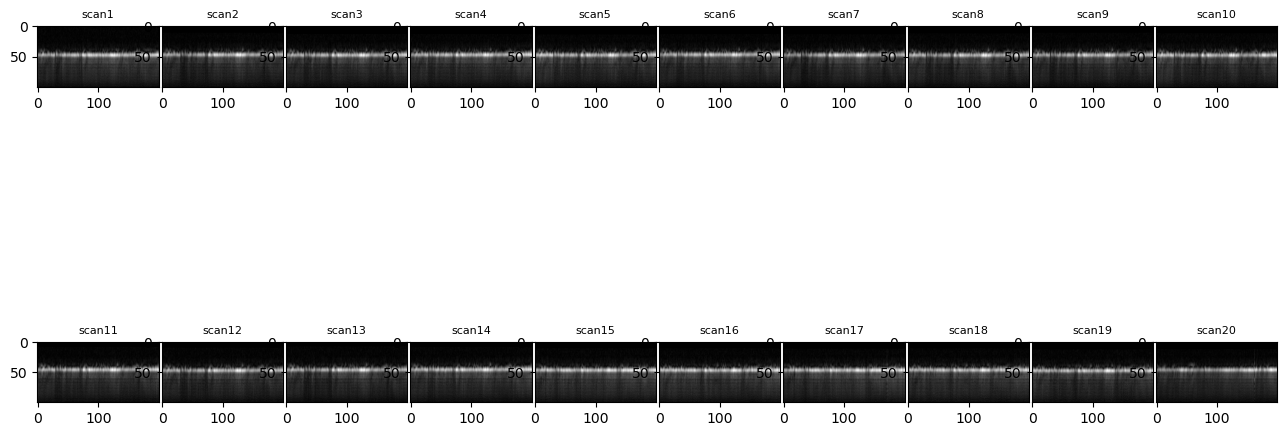

In [ ]:

# plt.figure(figsize=(16, 8))
# gs1 = gridspec.GridSpec(2, 10)
# gs1.update(wspace = 0.025, hspace = 0.05)

# framenum=0
# for i in range(20):
#     ax1 = plt.subplot(gs1[i])
#     plt.axis('on')
#     ax1.imshow(sparseSequence[framenum, :, :], cmap="gray")
#     plt.title(f'scan{framenum+1}', fontsize = 8)
#     ax1.set_aspect('equal')
#     framenum = framenum+1
# plt.show()


In [ ]:
# if floc == 0: #for save VLIV array
#     VLIV_save = np.zeros((numLocation, timePoints.shape[0]-1, height, width))

In [ ]:
# maxTimeWidth = np.nan
# OctSequence = sparseSequence
# timePoints = np.asarray(timePoints)
# A = np.ones((1,timePoints.shape[0]))
# B = np.asarray(timePoints.reshape(timePoints.shape[0],1))
# timePointMatrix = np.transpose(A*B) - A*B
# timePointMatrix[timePointMatrix<0] = 0.
# possibleMtw = np.unique(timePointMatrix)
# possibleMtw = possibleMtw[possibleMtw != 0.] # to remove the elemnt of 0.0

# # Reduce the time-region to be computed to meet with "maxTimeWidth"
# if np.isnan(maxTimeWidth):
#     pass
# else:
#     maxTimeWidth = np.asarray(maxTimeWidth)
#     possibleMtw = possibleMtw[possibleMtw <= maxTimeWidth] 

# logSparseSequence = 10*np.log10(OctSequence + 1e-8)
# logSparseSequence = np.asarray(logSparseSequence)             # for cupy computation
# VLIV = np.zeros((possibleMtw.shape[0], logSparseSequence.shape[1], logSparseSequence.shape[2]))

# # variance of variance
# VoV = np.zeros((possibleMtw.shape[0], logSparseSequence.shape[1], logSparseSequence.shape[2]))

In [ ]:
# possibleMtw

array([ 10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100., 110.,
       120., 130., 140.])

In [ ]:
# i = 0        
# for mtw in possibleMtw[0:2]:
#     A = np.ones((1,timePoints.shape[0]))
#     B = timePoints.reshape(timePoints.shape[0],1)
#     timePointMatrix = np.transpose(A*B) - A*B
#     validTimePointMatrix = (timePointMatrix <= mtw)*(timePointMatrix >= 0)

#     ##---------------------
#     ## Let's rewirte later as not to use for-loop
#     ##---------------------    
#     trueMtw = np.zeros(validTimePointMatrix.shape[0])
#     for j in range (0,validTimePointMatrix.shape[0]):
#         X = validTimePointMatrix[j,:]
#         X = timePoints[X]
#         Y = np.max(X) - np.min(X)
#         trueMtw[j] = Y
    
#     validTimePointMatrix = validTimePointMatrix[(trueMtw >= mtw),:]

#     # validTimePointMatrix = seekDataForMaxTimeWindow(timePoints, mtw)
#     validTimePointMatrix = np.asarray(validTimePointMatrix)    # for cupy computation 
    
#     # cupy compute
#     for m in range(0, validTimePointMatrix.shape[0]):
#         VLIV[i] = VLIV[i] + np.nanvar(logSparseSequence[validTimePointMatrix[m,:]],axis=0)
#         # newly added for LIV for each subset 


#     VLIV[i] = VLIV[i] / (validTimePointMatrix.shape[0])
    
#     # variance of variance (VoV) at a single time window (2D array)
    
#     i = i+1

In [ ]:
# validTimePointMatrix


array([[ True,  True,  True, False, False, False, False, False, False,
        False, False, False, False, False, False],
       [False,  True,  True,  True, False, False, False, False, False,
        False, False, False, False, False, False],
       [False, False,  True,  True,  True, False, False, False, False,
        False, False, False, False, False, False],
       [False, False, False,  True,  True,  True, False, False, False,
        False, False, False, False, False, False],
       [False, False, False, False,  True,  True,  True, False, False,
        False, False, False, False, False, False],
       [False, False, False, False, False,  True,  True,  True, False,
        False, False, False, False, False, False],
       [False, False, False, False, False, False,  True,  True,  True,
        False, False, False, False, False, False],
       [False, False, False, False, False, False, False,  True,  True,
         True, False, False, False, False, False],
       [False, False, Fa

In [8]:
for floc in tqdm(range(0,numLocation)):

    print(floc)
    sparseSequence, timePoints, frameindex = makeSparseDataFromRasterRepeat(concatenate_set, bscanLocationPerBlock, blockRepeat, floc)


    if floc == 0: #for save VLIV array
        VLIV_save = np.zeros((numLocation, timePoints.shape[0]-1, height, width))

    
    ## Compute VLIV
    VLIV , possibleMtw , VoV = computeVLIV(sparseSequence, timePoints, maxTimeWidth =  np.nan, compute_VoV = False)
    
    ## Average LIV curve
    if average_LivCurve == True:
        twIdx = 0
        for twIdx in range(0, VLIV.shape[0]):                
            VLIV[twIdx,:,:] = cv2.blur(VLIV[twIdx,:,:], (3,3))
            twIdx = twIdx + 1

    
    if fitting_method == 'CPU':
        mag, tau = vlivCPUFitExp(VLIV, possibleMtw, frameSeparationTime, alivInitial, swiftInitial, bounds, use_constraint = False)

    aliv [floc] = mag ## aLIV
    swift [floc] = 1/ tau ## Swiftness
    VLIV_save[floc,:,:,:] = VLIV ## LIV curve (VLIV)
        

  0%|          | 0/10 [00:00<?, ?it/s]

0


d:\xiaoliu_onedrive\OneDrive - Indiana University\lab\Dynamic_OCT\dynamic_oct_python\utils.py:153: RuntimeWarning: overflow encountered in exp
  return np.absolute(a) * (1 - np.exp(-Tw / tau))
d:\xiaoliu_onedrive\OneDrive - Indiana University\lab\Dynamic_OCT\dynamic_oct_python\utils.py:153: RuntimeWarning: overflow encountered in multiply
  return np.absolute(a) * (1 - np.exp(-Tw / tau))
d:\xiaoliu_onedrive\OneDrive - Indiana University\lab\Dynamic_OCT\dynamic_oct_python\utils.py:376: OptimizeWarning: Covariance of the parameters could not be estimated
  popt = curve_fit(LIV_fun,
 10%|█         | 1/10 [00:16<02:26, 16.25s/it]

1


 20%|██        | 2/10 [00:33<02:13, 16.64s/it]

2


 30%|███       | 3/10 [00:49<01:55, 16.50s/it]

3


 40%|████      | 4/10 [01:04<01:36, 16.08s/it]

4


 50%|█████     | 5/10 [01:20<01:19, 15.90s/it]

5


 60%|██████    | 6/10 [01:35<01:02, 15.68s/it]

6


 70%|███████   | 7/10 [01:51<00:47, 15.78s/it]

7


 80%|████████  | 8/10 [02:07<00:31, 15.70s/it]

8


 90%|█████████ | 9/10 [02:23<00:15, 15.93s/it]

9


100%|██████████| 10/10 [02:40<00:00, 16.03s/it]


In [40]:
with open("swift_Yusuno.npy", "wb") as f:
    np.save(f, swift)

with open("aliv_Yusuno.npy", "wb") as f:
    np.save(f, aliv)

with open("VLIV_Yusuno.npy", "wb") as f:
    np.save(f, VLIV_save)

In [31]:
stats.describe(swift)

DescribeResult(nobs=10, minmax=(array([[1.46838232e-04, 7.75295337e-05, 1.46406729e-04, ...,
        1.18366280e-04, 1.07121973e-04, 1.38980179e-04],
       [1.25122945e-04, 1.38473452e-04, 8.26104143e-05, ...,
        1.16823917e-04, 1.51938864e-04, 1.07398498e-04],
       [1.64579783e-04, 1.84840897e-04, 1.33082421e-04, ...,
        8.64252020e-05, 1.43281773e-04, 9.34683159e-05],
       ...,
       [4.61208491e+01, 4.29187594e+01, 4.33696043e+01, ...,
        4.76230504e+01, 4.05379079e+01, 3.71416264e+01],
       [5.18337356e+01, 4.79220832e+01, 4.43721666e+01, ...,
        4.94152293e+01, 4.43618435e+01, 3.77659534e+01],
       [4.75248421e+01, 4.74033968e+01, 4.21732650e+01, ...,
        4.96584150e+01, 4.52065105e+01, 3.95697567e+01]], shape=(100, 200)), array([[4.79464686e-04, 3.47353254e-04, 4.05468294e-04, ...,
        4.62352439e-04, 4.43468989e-04, 5.33457927e-04],
       [4.88619112e-04, 3.85370949e-04, 4.90136138e-04, ...,
        5.40163253e-04, 5.76930008e-04, 3.9818313

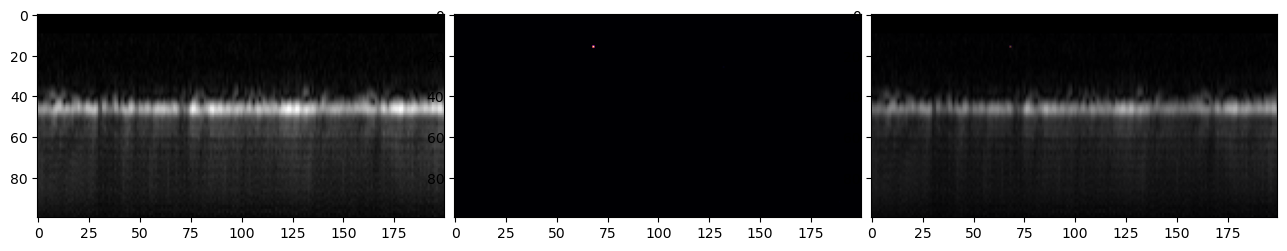

In [29]:
swift_normalized = cv2.normalize(swift[4, :, :,], None, 0, 255, cv2.NORM_MINMAX).astype(np.float64)
fourD_normalized = cv2.normalize(fourD_image[10, 4, :, :], None, 0, 255, cv2.NORM_MINMAX).astype(np.float64)
# fig, (ax1, ax2, ax3) = plt.subplots(figsize=(20, 60), ncols=3)
# fo = ax1.imshow(fourD_normalized, cmap="gray")
# sw = ax2.imshow(swift_normalized, cmap="inferno")
# co_n = ax3.imshow(fourD_normalized, cmap="gray")
# co_s = ax3.imshow(swift_normalized, cmap="inferno", alpha = 0.4)
# fig.colorbar(co_s, ax=ax3)

# plt.subplot(1, 3, 1)
# plt.imshow(fourD_normalized, cmap="gray")
# plt.subplot(1, 3, 2)
# plt.imshow(swift_normalized, cmap="inferno")
# plt.subplot(1, 3, 3)
# plt.imshow(fourD_normalized, cmap="gray")
# plt.imshow(swift_normalized, cmap="inferno", alpha=0.3)
# plt.colorbar()

plt.figure(figsize=(16, 8))
gs1 = gridspec.GridSpec(1, 3)
gs1.update(wspace = 0.025, hspace = 0.05)

ax1 = plt.subplot(gs1[0])
plt.axis('on')
ax1.imshow(fourD_normalized, cmap="gray")
ax1.set_aspect('equal')
ax2 = plt.subplot(gs1[1])
plt.axis('on')
ax2.imshow(swift_normalized, cmap="inferno")
ax2.set_aspect('equal')
ax3 = plt.subplot(gs1[2])
plt.axis('on')
ax3.imshow(fourD_normalized, cmap="gray")
ax3.imshow(swift_normalized, cmap="inferno", alpha=0.3)
ax1.set_aspect('equal')
plt.show()

In [1]:
np.max(swift[4, :, :])
# np.unravel_index(np.argmax(swift), swift.shape)

NameError: name 'np' is not defined

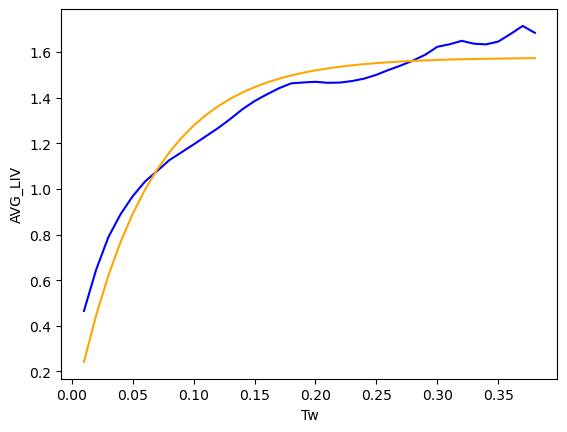

In [ ]:
cord = [4, 50, 30]#coordinate
time = possibleMtw
mag = aliv[cord[0], cord[1], cord[2]]
tau = 1 / swift[cord[0], cord[1], cord[2]]
fit_LIV = LIV_fun(possibleMtw*frameSeparationTime, mag, tau)
plt.plot(possibleMtw*frameSeparationTime, VLIV_save[cord[0], :, cord[1], cord[2]], color = "blue")
plt.plot(possibleMtw*frameSeparationTime, fit_LIV, color = "orange")
plt.xlabel("Tw")
plt.ylabel("AVG_LIV")
plt.show()